# 1. PARAMETERS

In [1]:
####### CONFIGURATION

class CFG:

    # environment
    environment = 'local'   # work environment ['kaggle', 'colab', 'local']
    device      = 'GPU'     # device ['CPU', 'GPU', 'TPU']
    gpu_index   = 0         # GPU device index
    cpu_workers = 4         # no. CPU cores (data loading)
    tpu_workers = 8         # no. TPU cores [1, 8]

    # general
    version  = 12     # notebook version (for saving outputs)
    debug    = False  # debug mode runs 8 batches for 2 epochs on 2 folds
    seed     = 13353  # random state

    # data
    num_folds = 5      # number of CV folds
    data_pl   = False  # False or percentage of appended pseudo-labeled data 
    
    # image augmentations
    image_size = 600              # image size after random crop
    channels   = 3                # number of color channels
    crop_scale = (0.8, 1)         # min scale, max scale
    ssr        = [0.05, 0.05, 5]  # shift, scale, rotation limits
    huesat     = [11, 11, 11]     # hue, saturation, value limits
    bricon     = [0.11, 0.11]     # brightness, contrast limits
    blur_limit = 3                # blur limit
    dist_limit = 0.1              # distortion limit
    cutout     = [5, 0.1]         # number of squares, size of squares
    p_aug      = 0.5              # prob. of augmentations except for flips
    normalize  = 'imagenet'       # pixel normalization [False, 'imagenet', 'custom']

    # model architecture
    backbone  = 'tf_efficientnet_b7_ns'  # convolutional backbone
    weights   = 'imagenet'               # weights ['empty', 'imagenet', path to custom weights]
    attention = False                    # whether to include attention module (efficientnet only)
    save_all  = False                    # save weights from each epoch

    # training
    batch_size  = 12      # no. images per batch
    num_epochs  = 15      # no. epochs per fold
    fine_tune   = False   # fine-tuning head after training (False or no. epochs)
    accum_iter  = 3       # no. batches for gradient accumalation
    use_amp     = True    # automated mixed precision mode

    # learning rate and optimizer
    eta     = 1e-3    # starting learning rate
    eta_min = 1e-6    # ending learning rate
    optim   = 'AdamP' # LR optimizer ['Adam', 'AdamW', 'AdamP']
    decay   = 1e-6    # weight decay of optimizer (L2 regularization)

    # learning rate scheduler
    warmup          = 1                  # no. epochs for warmup
    schedule        = 'CosineAnnealing'  # LR scheduler after warmup
    update_on_batch = True               # update LR after every batch (or epoch)

    # loss function
    loss_fn = 'BCE'  # loss ['BCE', 'FC']
    
    # epoch-based changes
    step_size  = False  # False or list with image_size for each epoch
    step_p_aug = [0.40, 0.40, 0.40,
                  0.45, 0.45, 0.45, 
                  0.50, 0.50, 0.50, 
                  0.55, 0.55, 0.55, 
                  0.60, 0.60, 0.60]  # False or list with p_aug for each epoch

    # inference
    num_tta = 2  # no. TTA flips (between 1 and 2)

In [2]:
####### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

In [3]:
####### UPDATES FOR DEBUG MODE

if CFG['debug']:
    CFG['save_all']   = False
    CFG['num_folds']  = 2
    CFG['num_epochs'] = 2
    CFG['fine_tune']   = False

# 2. PREPARATIONS

## PACKAGES

In [4]:
####### PACKAGES FOR TPU

if CFG['device'] == 'TPU':
        
    # install XLA
    xla_version = 'nightly' # (1.7, 'nightly')
    !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    !python pytorch-xla-env-setup.py --version $xla_version

    # settings
    import os
    if CFG['environment'] == 'colab':
        assert os.environ['COLAB_TPU_ADDR']
    os.environ['XLA_USE_BF_16'] = '1'
    os.environ['XLA_TENSOR_ALLOCATOR_MAXSIZE'] = '100000000'

    # imports
    import torch_xla
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.xla_multiprocessing as xmp
    import torch_xla.distributed.parallel_loader as pl

In [5]:
####### PACKAGES

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler, WeightedRandomSampler
from torch.utils.data.distributed import DistributedSampler
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.autograd import Function

import sys
if CFG['environment'] == 'kaggle':
    sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
else:
    !pip install git+'https://github.com/rwightman/pytorch-image-models.git'
import timm
from timm.utils import *

from contextlib import suppress

!pip install --upgrade -U albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

!pip install git+'https://github.com/ildoonet/pytorch-gradual-warmup-lr.git'
from warmup_scheduler import GradualWarmupScheduler  

!pip install adamp
from adamp import AdamP

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from scipy.special import softmax

from tqdm import tqdm

import random
import math
import time
import os
import pickle

import gc
gc.enable()

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-o1ul6tny
  Running command git clone -q https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-o1ul6tny
  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-5pdgetee
  Running command git clone -q https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-5pdgetee


## ENVIRONMENT

In [6]:
####### COLAB DATA DOWNLOAD

if (CFG['environment'] == 'colab') and (not os.path.exists('/content/input/')):

    # mount drive
    from google.colab import drive
    drive.mount('/content/drive')  

    # set up Kaggle API
    !pip install --upgrade --force-reinstall --no-deps -q kaggle
    !mkdir -p ~/.kaggle
    !cp '/content/drive/MyDrive/Competitions/kaggle.json' ~/.kaggle/
    !ls ~/.kaggle

    # download data
    !mkdir '/content/input/'
    !kaggle competitions download -c ranzcr-clip-catheter-line-classification
    !unzip -o -q '/content/ranzcr-clip-catheter-line-classification.zip' -d '/content/input/'
    !rm -rf '/content/ranzcr-clip-catheter-line-classification.zip'

In [7]:
####### WORKING PATHS

# kaggle
if CFG['environment'] == 'kaggle':
    CFG['data_path']  = '/kaggle/input/ranzcr-clip-catheter-line-classification/'
    CFG['out_path']   = ''

# colab
if CFG['environment'] == 'colab':
    CFG['data_path']  = '/content/input/'
    CFG['out_path']   = '/content/drive/MyDrive/Competitions/ranzcr/output/v' + str(CFG['version']) + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])

# local
if CFG['environment'] == 'local':
    CFG['data_path']  = '../input/'
    CFG['out_path']   = '../output/v' + str(CFG['version']) + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])

In [8]:
####### DEVICE SETTINGS

if CFG['device'] == 'TPU':
    print('Training on TPU...')
    device      = torch.device('cpu')
    serial_exec = xmp.MpSerialExecutor()
    
if CFG['device'] == 'GPU':
    print('Training on GPU {}...'.format(CFG['gpu_index']))
    device = torch.device('cuda:{}'.format(CFG['gpu_index']))

if CFG['device'] == 'CPU':
    print('Training on CPU...')
    device = torch.device('cpu') 
    
amp_autocast = suppress
if CFG['use_amp'] and CFG['device'] == 'GPU':
    amp_autocast = torch.cuda.amp.autocast
    scaler       = torch.cuda.amp.GradScaler()       

Training on GPU 0...


## MODULES

In [9]:
####### IMPORT MODULES

sys.path.append('../codes')

# utilities
from utilities import get_score, smart_print, smart_save, seed_everything

# data processing
from data import get_data, get_loaders, ImageData
from augmentations import get_augs, get_tta_flips

# model
from model import get_model
from optimizers import get_optimizer
from losses import get_losses, FocalCosineLoss

# training and inference
from training import train_epoch, valid_epoch
from run_fold import run_fold, run_on_tpu
from plot_results import plot_results
    
seed_everything(CFG['seed'], CFG)

- setting random seed to 13353...


# 3. DATA PREP

In [11]:
####### PARTITIONING

# import data
df = pd.read_csv(CFG['data_path'] + 'train_folds.csv')

# num classes
CFG['targets'] = ['ETT - Abnormal', 
                  'ETT - Borderline', 
                  'ETT - Normal', 
                  'NGT - Abnormal', 
                  'NGT - Borderline', 
                  'NGT - Incompletely Imaged', 
                  'NGT - Normal', 
                  'CVC - Abnormal',
                  'CVC - Borderline', 
                  'CVC - Normal', 
                  'Swan Ganz Catheter Present']
CFG['num_classes'] = len(CFG['targets'])

# check folds
df['fold'].value_counts()

1    6041
4    6030
3    6018
0    6003
2    5991
Name: fold, dtype: int64

In [12]:
####### PSEUDO-LABELED DATA

if CFG['data_pl']:

    # import
    df_pl = pd.read_csv(CFG['data_path'] + 'submission.csv')
    df_pl['fold'] = -1
    
    # compute confidence
    tmp_df = df_pl.copy()
    for c in CFG['targets']:
        tmp_df.loc[tmp_df[c] < 0.5, c] = 1 - tmp_df.loc[tmp_df[c] < 0.5, c]
    df_pl['confidence'] = tmp_df[CFG['targets']].mean(axis = 1)

    # filter confident predictions
    df_pl = df_pl.sort_values('confidence', ascending = False).reset_index(drop = True)
    df_pl = df_pl.head(int(CFG['data_pl'] * len(df_pl)))
    del df_pl['confidence']

    # check classes
    display(df_pl['fold'].value_counts())

- batch shape:  torch.Size([5, 3, 128, 128]) vs torch.Size([5, 3, 128, 128])
- loading time: 0.5292 vs 0.2477 seconds
- pixel values: -2.12 - 0.26 - 2.45 vs -2.12 - 0.19 - 2.64


0

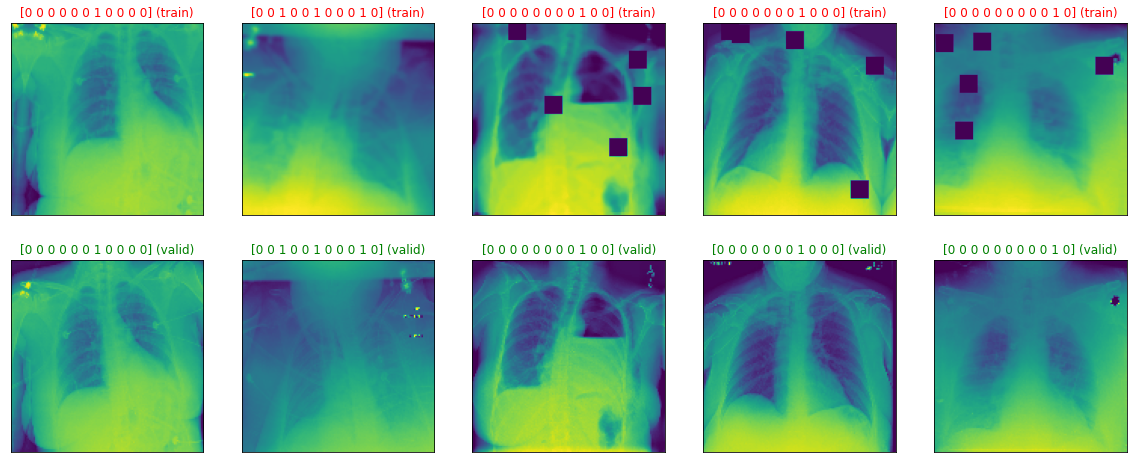

In [16]:
####### EXAMINE SAMPLE BATCH

# sample size
sample = 5

# augmentations
train_augs, valid_augs = get_augs(CFG, image_size = 128)

# datasets
train_dataset = ImageData(df        = df.head(sample), 
                          path      = CFG['data_path'] + 'train/',
                          transform = train_augs,
                          labeled   = True,
                          indexed   = False)
valid_dataset = ImageData(df        = df.head(sample), 
                          path      = CFG['data_path'] + 'train/',
                          transform = valid_augs,
                          labeled   = True,
                          indexed   = False)

# data loaders
train_loader = DataLoader(dataset     = train_dataset, 
                          batch_size  = sample, 
                          shuffle     = False, 
                          num_workers = 0)
valid_loader = DataLoader(dataset     = valid_dataset, 
                          batch_size  = sample, 
                          shuffle     = False, 
                          num_workers = 0)

# display train images
batch_time = time.time()
for batch_idx, (inputs, labels) in enumerate(train_loader):

    # feedback
    inputs_shape = inputs.shape
    load_time    = time.time() - batch_time
    pixel_values = [torch.min(inputs).item(), torch.mean(inputs).item(), torch.max(inputs).item()]

    # examples
    fig = plt.figure(figsize = (20, 8))
    for i in range(sample):
        ax = fig.add_subplot(2, sample, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy()[0, :, :])
        ax.set_title('{} (train)'.format(labels[i].numpy().astype('int')), color = 'red')
    break

# display valid images
batch_time = time.time()
for batch_idx, (inputs, labels) in enumerate(valid_loader):
                
    # feedback
    print('- batch shape:  {} vs {}'.format(inputs_shape, inputs.shape))
    print('- loading time: {:.4f} vs {:.4f} seconds'.format(load_time, (time.time() - batch_time)))
    print('- pixel values: {:.2f} - {:.2f} - {:.2f} vs {:.2f} - {:.2f} - {:.2f}'.format(
        pixel_values[0], pixel_values[1], pixel_values[2],
        torch.min(inputs).item(), torch.mean(inputs).item(), torch.max(inputs).item()))

    # examples
    for i in range(sample):
        ax = fig.add_subplot(2, sample, sample + i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy()[0, :, :])
        ax.set_title('{} (valid)'.format(labels[i].numpy().astype('int')), color = 'green')
    plt.savefig(CFG['out_path'] + 'fig_sample.png')
    break
    
# clean up
del inputs, labels, batch_idx, train_loader, valid_loader, train_dataset, valid_dataset, train_augs, valid_augs, pixel_values
gc.collect()

# 4. CROSS-VALIDATION

In [28]:
####### CROSS-VALIDATION LOOP

# timer
cv_start = time.time()

# clear memory
gc.collect()

# placeholders
oof = None

# cross-validation
for fold in range(CFG['num_folds']):
        
    # feedback
    print('-' * 55)
    print('FOLD {:d}/{:d}'.format(fold + 1, CFG['num_folds']))    
    print('-' * 55) 

    # prepare model
    model = get_model(CFG, device)
    model.load_state_dict(torch.load(CFG['out_path'] + 'weights_fold{}.pth'.format(fold), map_location = device))
    
    # prepare data
    df_trn, df_val = get_data(df, fold, CFG)  
    
    # training and inference
    if CFG['device'] != 'TPU':
        trn_losses, val_losses, val_metrics, val_preds_best = run_fold(fold, df_trn, df_val, CFG, model, device)
    else:
        xmp.spawn(run_on_tpu, args = (CFG, ), nprocs = CFG['tpu_workers'], start_method = 'fork')
        trn_losses     = np.load('trn_losses.npy')
        val_losses     = np.load('val_losses.npy')
        val_metrics    = np.load('val_metrics.npy')
        val_preds_best = np.load('val_preds_best.npy')
            
    # export OOF predictions
    val_preds_df = pd.DataFrame(val_preds_best, columns = ['pred ' + c for c in CFG['targets']])
    val_preds_df = pd.concat([df_val, val_preds_df], axis = 1)
    oof          = pd.concat([oof,    val_preds_df], axis = 0).reset_index(drop = True)
    oof.to_csv(CFG['out_path'] + 'oof.csv', index = False)
    
    # feedback
    print('-' * 55)
    print('Best: auc = {:.4f} (epoch {}), loss = {:.4f} (epoch {})'.format(
        np.max(val_metrics), np.argmax(val_metrics) + 1, np.min(val_losses), np.argmin(val_losses) + 1))
    print('-' * 55)

    # plot loss dynamics
    plot_results(trn_losses, val_losses, val_metrics, fold, CFG)
    

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

-------------------------------------------------------
FOLD 1/5
-------------------------------------------------------
- no. images: train - 24080, valid - 6003
- setting random seed to 13353...
- image size: 600x600, p(augment): 0.5
-------------------------------------------------------
- image size: 600x600, p(augment): 0.4


100%|██████████| 501/501 [08:49<00:00,  1.06s/it]


-- epoch 1/15 | lr = 0.000000 | trn_loss = 0.0000 | val_loss = 0.1363 | val_auc = 0.9515 | 8.83 min
-------------------------------------------------------
Best: auc = 0.9515 (epoch 1), loss = 0.1363 (epoch 1)
-------------------------------------------------------
-------------------------------------------------------
FOLD 2/5
-------------------------------------------------------
- no. images: train - 24042, valid - 6041
- setting random seed to 13354...
- image size: 600x600, p(augment): 0.5
-------------------------------------------------------
- image size: 600x600, p(augment): 0.4


100%|██████████| 504/504 [08:53<00:00,  1.06s/it]


-- epoch 1/15 | lr = 0.000000 | trn_loss = 0.0000 | val_loss = 0.1343 | val_auc = 0.9504 | 8.91 min
-------------------------------------------------------
Best: auc = 0.9504 (epoch 1), loss = 0.1343 (epoch 1)
-------------------------------------------------------
-------------------------------------------------------
FOLD 3/5
-------------------------------------------------------
- no. images: train - 24092, valid - 5991
- setting random seed to 13355...
- image size: 600x600, p(augment): 0.5
-------------------------------------------------------
- image size: 600x600, p(augment): 0.4


100%|██████████| 500/500 [08:37<00:00,  1.03s/it]


-- epoch 1/15 | lr = 0.000000 | trn_loss = 0.0000 | val_loss = 0.1348 | val_auc = 0.9547 | 8.63 min
-------------------------------------------------------
Best: auc = 0.9547 (epoch 1), loss = 0.1348 (epoch 1)
-------------------------------------------------------
-------------------------------------------------------
FOLD 4/5
-------------------------------------------------------
- no. images: train - 24065, valid - 6018
- setting random seed to 13356...
- image size: 600x600, p(augment): 0.5
-------------------------------------------------------
- image size: 600x600, p(augment): 0.4


100%|██████████| 502/502 [09:06<00:00,  1.09s/it]


-- epoch 1/15 | lr = 0.000000 | trn_loss = 0.0000 | val_loss = 0.1309 | val_auc = 0.9532 | 9.11 min
-------------------------------------------------------
Best: auc = 0.9532 (epoch 1), loss = 0.1309 (epoch 1)
-------------------------------------------------------
-------------------------------------------------------
FOLD 5/5
-------------------------------------------------------
- no. images: train - 24053, valid - 6030
- setting random seed to 13357...
- image size: 600x600, p(augment): 0.5
-------------------------------------------------------
- image size: 600x600, p(augment): 0.4


100%|██████████| 503/503 [09:10<00:00,  1.09s/it]


-- epoch 1/15 | lr = 0.000000 | trn_loss = 0.0000 | val_loss = 0.1420 | val_auc = 0.9508 | 9.19 min
-------------------------------------------------------
Best: auc = 0.9508 (epoch 1), loss = 0.1420 (epoch 1)
-------------------------------------------------------

Finished in 50.94 minutes


# 5. EVALUATION

In [29]:
####### CHECK OOF PERFORMANCE

# compute metric
oof_auc, oof_aucs = get_score(oof[CFG['targets']].values, 
                              oof[['pred ' + c for c in CFG['targets']]].values)

# compute loss
_, criterion = get_losses(CFG, device)
oof_loss = criterion(torch.tensor(oof[['pred ' + c for c in CFG['targets']]].values),
                     torch.tensor(oof[CFG['targets']].values).float()).item()

# print results
print('-' * 38)
print('OOF mean AUC = {:.4f}'.format(oof_auc))
print('-' * 38)
for idx, auc in enumerate(oof_aucs):
    print('- {:.4f}: {}'.format(auc, CFG['targets'][idx]))
print('-' * 38)
print('OOF loss = {:.4f}'.format(oof_loss))
print('-' * 38)

--------------------------------------
OOF mean AUC = 0.9505
--------------------------------------
- 0.9768: ETT - Abnormal
- 0.9655: ETT - Borderline
- 0.9915: ETT - Normal
- 0.9431: NGT - Abnormal
- 0.9386: NGT - Borderline
- 0.9803: NGT - Incompletely Imaged
- 0.9825: NGT - Normal
- 0.9157: CVC - Abnormal
- 0.8496: CVC - Borderline
- 0.9147: CVC - Normal
- 0.9976: Swan Ganz Catheter Present
--------------------------------------
OOF loss = 0.6680
--------------------------------------


In [30]:
####### EXAMINE WRONG PREDICTIONS [1]

# images per label
sample = 4

# get augmentations
_, sample_augs = get_augs(CFG, image_size = 128)

# prepare dataframes
wrongs = None
for target in CFG['targets']:
    sorted_oof  = oof.sort_values(['pred ' + target], ascending = True)
    sorted_oof1 = sorted_oof.loc[sorted_oof[target] == 1].head(int(sample / 2)).reset_index(drop = True)
    sorted_oof2 = sorted_oof.loc[sorted_oof[target] == 0].tail(int(sample / 2)).reset_index(drop = True)
    wrongs      = pd.concat([wrongs, sorted_oof1, sorted_oof2], axis = 0).reset_index(drop = True)

# datasets
wrong_dataset = ImageData(df        = wrongs,  
                          path      = CFG['data_path'] + 'train/',
                          transform = sample_augs,
                          labeled   = True)
# data loaders
wrong_loader = DataLoader(dataset     = wrong_dataset, 
                          batch_size  = sample,
                          shuffle     = False, 
                          num_workers = CFG['cpu_workers'],
                          pin_memory  = True)

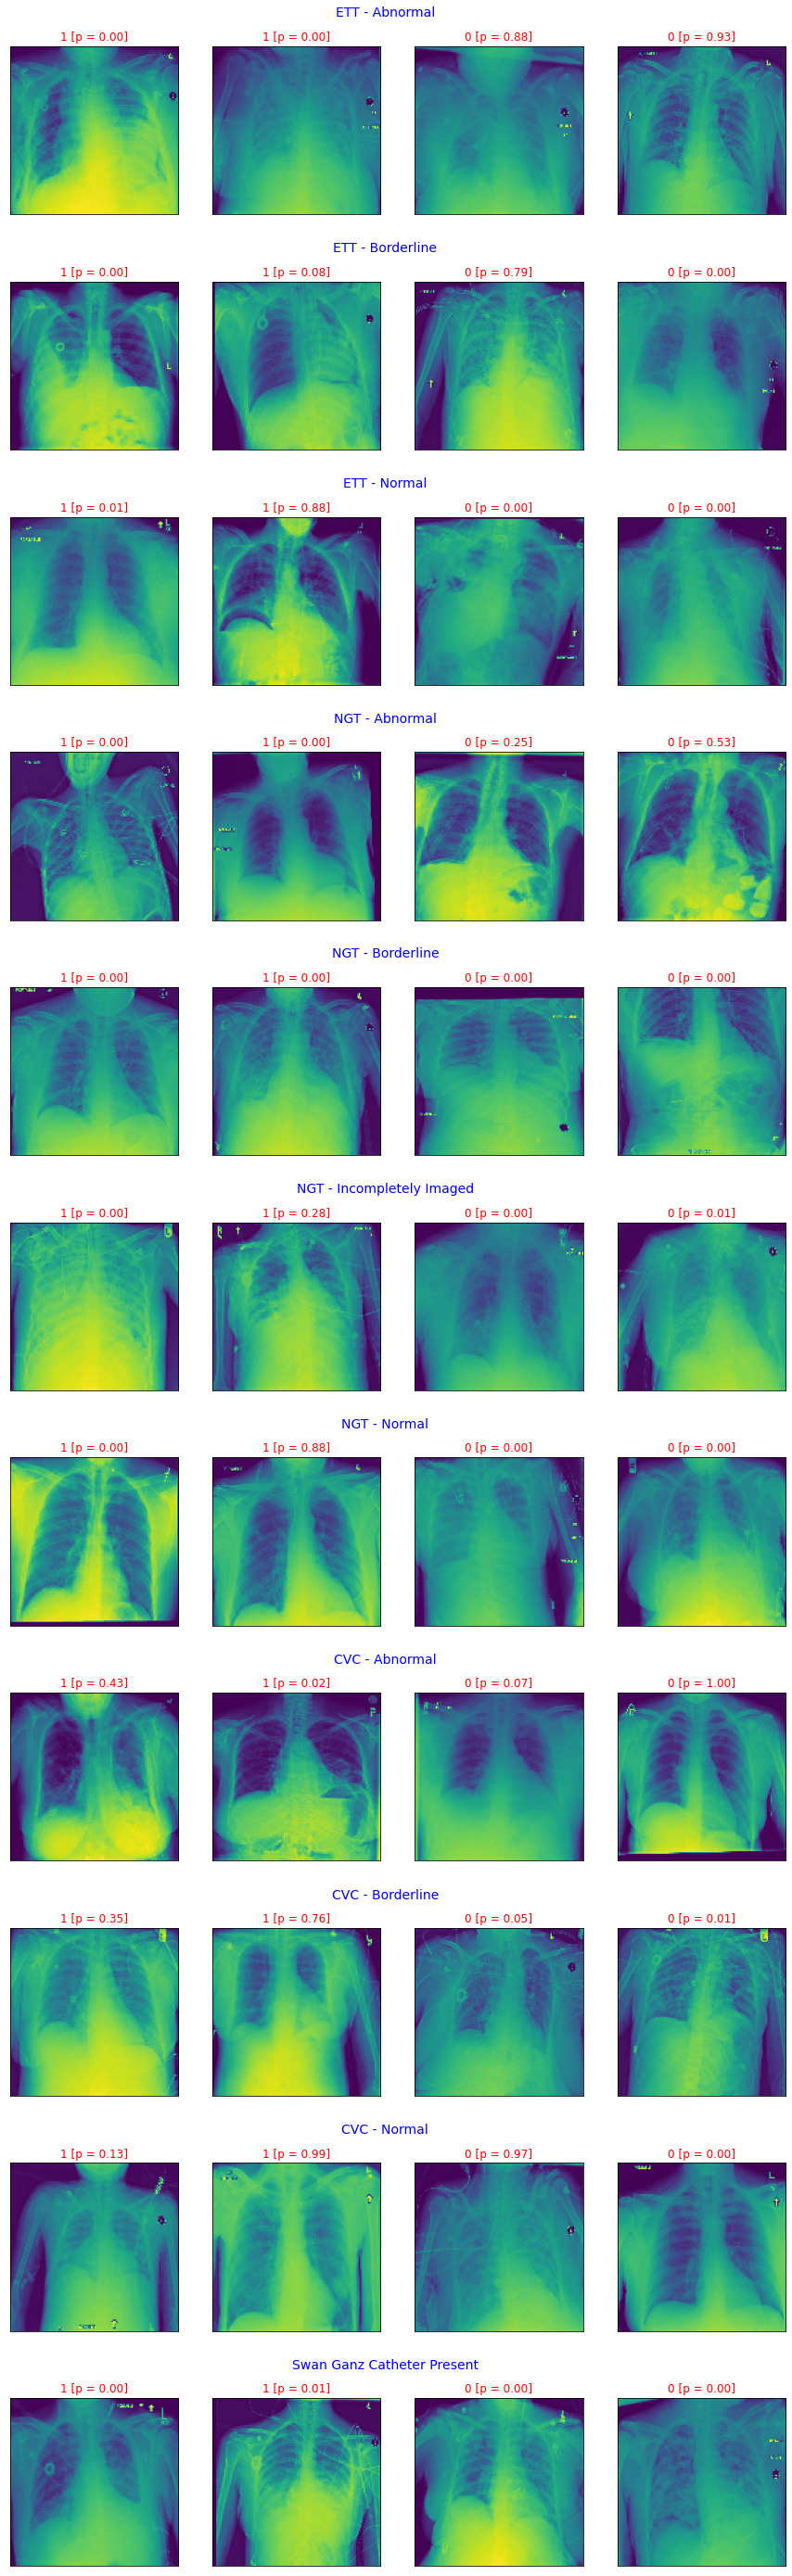

In [31]:
####### EXAMINE WRONG PREDICTIONS [2]

# display and save image grid
fig = plt.figure(figsize = (15, 50))
for batch_idx, (inputs, labels) in enumerate(wrong_loader):
    
    for i in range(inputs.shape[0]):

        # compute gradcam
        if False: #('vit' not in CFG['backbone']) and (not CFG['attention']):
            grayscale_cam = grad_cam(inputs[i].unsqueeze(0), None)
            image         = show_cam_on_image(inputs[i].numpy().transpose(1, 2, 0), grayscale_cam)
        else:
            image = inputs[i].numpy()[0, :, :]

        # display image
        ax = fig.add_subplot(CFG['num_classes'], sample, (batch_idx * sample) + i + 1, xticks = [], yticks = [])     
        ax.imshow(image)
        
        # add labels
        ax.set_title('{} [p = {:.2f}]'.format(
            int(labels[i].numpy()[batch_idx]), wrongs.iloc[i][['pred ' + c for c in CFG['targets']]].values[batch_idx]), color = 'red')

# export
t_null = 0.892
for t in range(len(CFG['targets'])):
    plt.figtext(0.5, t_null - t*0.0705, CFG['targets'][t], ha = 'center', va = 'top', fontsize = 14, color = 'blue')
plt.subplots_adjust(hspace = 0.4)
plt.savefig(CFG['out_path'] + 'fig_mistakes.png')

In [32]:
####### EXPORT CONFIGURATION

# store performance values
CFG['time_hours'] = (time.time() - cv_start) / 3600
CFG['oof_auc']    = oof_auc
CFG['oof_loss']   = oof_loss

# save dictionary
pickle.dump(CFG, open(CFG['out_path'] + 'configuration.pkl', 'wb'))